# Classification de données multimodales

## Lecture des données

Les fichiers CSV contiennent les données audio et le chemin des images pour chaque scène. Le fichier d'entraînement contient en plus les classes associées. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# datadir = '/kaggle/input/iogs-atsi-multimodal'
datadir = 'iogs-atsi-multimodal'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


data_df = pd.read_csv(os.path.join(datadir,'data_train.csv'), delimiter=',', nrows = None)
data = np.array(data_df)

labels = data[:,-1].astype('int32')

audio = data[:, 1:-1].astype('float32')

img_list = data_df['IMAGE']



On fixe les seed pour la reproductibilité des résultats

In [2]:
import torch
import random

torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Séparation des données en ensembles de train et validation

On sépare les données en 2 ensembles : 1 ensemble d'entraînement et 1 ensemble de validation.
L'ensemble de validation sert à comparer les choix de modèles et d'hyperparamètres entre eux.

In [3]:
from sklearn.model_selection import train_test_split

img_train, img_val, audio_train, audio_val, y_train, y_val = train_test_split(img_list, audio, 
                                                                              labels, test_size=0.33,
                                                                             random_state=33)

## Images

On commence par faire une classification n'utilisant que les images. Une façon simple de faire cela est d'utiliser un réseau de neurone convolutionnel préentrainé. PyTorch propose des réseaux préentrainés sur le dataset ImageNet, qui contient plusieurs millions d'images. Ces réseaux sont entraînés pour un problème de classification différent, il faut donc modifier la dernière couche et la réentraîner sur nos données.
Cela fonctionne car les images de ImageNet sont de natures similaires à celles de notre jeu de données (ce sont aussi des photographies), et que le réseau privé de sa dernière couche peut être vu comme une sorte  d'extracteur de features.

### Visualisation des images

JUNGLE


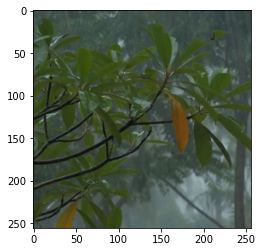

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# visu image
idx = 5
class_list = ['FOREST', 'CITY', 'BEACH', 'CLASSROOM', 'RIVER', 'JUNGLE', 'RESTAURANT', 'GROCERY-STORE', 'FOOTBALL-MATCH']
img = Image.open(f'{datadir}/data/data/{img_train.iloc[idx]}')
plt.imshow(np.asarray(img))
print(class_list[y_train[idx]])

### Datasets pour PyTorch

On définit une classe ImageAudioDataset pour PyTorch. La classe définit une fonction pour charger les images qui renvoie un couple (image, données audio) ou un triplet (image, données audio, label).

In [5]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class ImageAudioDataset(Dataset):
    def __init__(self, root_dir, files, audio, labels=None, img_transform=None, audio_transform=None):
        self.root_dir = root_dir
        self.files = files
        self.audio = audio
        self.labels = labels
        self.img_transform = img_transform
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(f'{self.root_dir}{self.files.iloc[idx]}')
        audio = self.audio[idx,:]
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.audio_transform is not None:
            audio = self.audio_transform(audio)
        if self.labels is not None:
            return img, audio, int(self.labels[idx])
        else:
            return img, audio

Sur Windows il faut mettre la classe dans un fichier à part et exécuter la cellule suivante.

In [6]:
if os.name == 'nt':
    from datasets import ImageAudioDataset

La fonction suivante permet d'entraîner un modèle PyTorch. Elle garde le modèle qui a la meilleure précision sur l'ensemble de validation. On pourra réutiliser la même fonction pour entrainer un classifieur se basant seulement sur l'audio ou sur l'audio et les images à la fois.

In [7]:
import copy
import time

def train(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10, input_type='image'):
    loss_vals = []
    train_acc_vals = []
    val_acc_vals = []
    best_val_acc = 0.0
    best_train_acc = 0.0
    best_model_state = copy.deepcopy(model.state_dict())
    
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        epoch_loss = []
        running_loss = 0.0
        train_acc = 0.0
        for i, data in enumerate(train_loader):   ## on itere sur les données 
            img, audio, targets = data
            img, audio, targets = img.cuda(), audio.cuda(), targets.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                if input_type == 'image':
                    outputs = model(img)
                elif input_type == 'audio':
                    outputs = model(audio)
                elif input_type == 'multimodal':
                    outputs = model(img, audio)
                else:
                    raise ValueError('input_type should be one of "image", "audio" or "multimodal"')

                loss = criterion(outputs,targets)  ## on compare la sortie courante à la sortie voulue
                _,pred = outputs.max(1)
                train_acc += torch.sum(pred == targets)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss.append(loss.item())

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        
        loss_val = sum(epoch_loss)/len(epoch_loss)
        train_acc = train_acc / len(train_loader.dataset)
        if scheduler is not None:
            scheduler.step(loss_val)
            print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
            
        loss_vals.append(loss_val)
        train_acc_vals.append(train_acc)

        # calcul précision validation
        if val_loader is not None:
            val_acc = 0.0
            model.eval()
            with torch.no_grad():  ### ici pas besoin de calculer les gradients
                for img, audio, targets in val_loader:
                    img = img.cuda()
                    audio = audio.cuda()
                    targets = targets.cuda()
                    with torch.cuda.amp.autocast():
                        if input_type == 'image':
                            outputs = model(img)
                        elif input_type=='audio':
                            outputs = model(audio)
                        elif input_type == 'multimodal':
                            outputs = model(img, audio)
                        else:
                            raise ValueError('input_type should be one of "image", "audio" or "multimodal"')

                        #print(outputs)
                        _,pred = outputs.max(1)
                        val_acc += torch.sum(pred == targets)

            val_acc = val_acc / len(val_loader.dataset)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = copy.deepcopy(model.state_dict())
            val_acc_vals.append(val_acc)
            print(f'Train accuracy: {train_acc}, validation accuracy : {val_acc}')
        else:
            if train_acc > best_train_acc:
                best_train_acc = train_acc
                best_model_state = copy.deepcopy(model.state_dict())         
            print(f'Train accuracy: {train_acc}')
            
        print(f'Epoch duration : {time.time() - epoch_start}')
    
    model.load_state_dict(best_model_state)
    if val_loader is None:
        return model, loss_vals, train_acc_vals
    else:
        return model, loss_vals, train_acc_vals, val_acc_vals

La fonction suivante renvoie les prédictions d'un modèle, et éventuellement les données ayant entraîné une mauvaise prédiction.

In [8]:
def predict(model, dataloader, has_labels=False, input_type='image'):
    model.eval()
    v=[]
    incorrect_pred=[]
    with torch.no_grad():  ### ici pas besoin de calculer les gradients
        for data in dataloader:
            if has_labels:
                img, audio, labels = data
            else:
                img, audio = data
            img = img.cuda()
            audio = audio.cuda()
            
            if input_type == 'image':
                outputs = model(img)
            elif input_type=='audio':
                outputs = model(audio)
            elif input_type == 'multimodal':
                outputs = model(img, audio)
            else:
                raise ValueError('input_type should be one of "image", "audio" or "multimodal"')
            
            _,pred = outputs.max(1)
            
            if has_labels:
                for i, p in enumerate(pred):
                    if p != labels[i]:
                        incorrect_pred.append((img[i,:], audio[i,:], labels[i], pred[i]))

            v.append(pred.cpu())
    
    v = torch.cat(v, 0)
    
    if has_labels:
        return v, incorrect_pred
    else:
        return v

Le réseau utilisé est un réseau ResNeXt50_32x4d préentrainé sur ImageNet (l'architecture est décrite ici : https://arxiv.org/abs/1611.05431). Les images sont normalisées par canal selon les coefficients donnés dans le code, comme préconisé par la documentation de PyTorch.
Pour l'entraînement, des transformations aléatoires (crop, retournement horizontal) sont opérés pour limiter le surapprentissage (c'est une forme de data augmentation). Ces transformations sont faites sur chaque batch à chaque epoch, le réseau ne verra donc jamais exactement deux fois la même image.

On choisit une taille de batch de 16 pour l'entraînement. Nous avons aussi testé les tailles 32 et 64, qui donnaient des résultats légèrement moins bons.

In [9]:
import torchvision


img_train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img_val_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
audio_transform = None

train_dataset = ImageAudioDataset(root_dir=f'{datadir}/data/data/',
                           files=img_train,
                                 audio=audio_train,
                                 labels=y_train,
                          img_transform=img_train_transform,
                                 audio_transform=audio_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ImageAudioDataset(root_dir=f'{datadir}/data/data/',
                           files=img_val,
                           audio=audio_val,
                           labels=y_val,
                          img_transform=img_val_transform,
                             audio_transform=audio_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

Le code suivant crée le réseau ResNext et charge les coefficients du modèle préentrainé. On remplace la dernière couche (qui a 1000 sorties par défaut) par une couche à 9 sorties, une pour chaque classe. 

In [10]:
import torchvision.models
import torch
import torch.nn as nn
import torch.nn.functional as F

resnext = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)

for param in resnext.parameters(): # on ne calcule les gradients que pour la dernière couche
    param.requires_grad = False
    
num_ftrs = resnext.fc.in_features
resnext.fc = nn.Linear(num_ftrs, 9)

resnext = resnext.cuda()

Pour l'entraînement on choisir comme learning rate de départ 0.001. Il est divisé par 2 à chaque epoch où la valeur de loss ne diminue pas. Ces paramètres ont été choisis après plusieurs expérimentations, ce sont ceux qui nous ont donné les meilleurs résultats sur l'ensemble de validation. On n'entraine que la dernière couche, donc il faut ne passer que les paramètres de la dernière couche à l'optimiseur.

In [11]:
from torch.optim import lr_scheduler
import torch.optim as optim

optimizer = optim.Adam(resnext.fc.parameters(), lr=0.001) # on optimise seulement les coeffs de la dernière couche
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5) # permet de réduire le learning rate quand la loss ne diminue pas

Le code suivant entraîne le réseau pour le nombre d'epochs spécifié (1 epoch = 1 passage sur toutes les données d'entraînement).

In [12]:
import matplotlib.pyplot as plt

num_epochs = 30
resnext, loss_vals, train_acc_vals, val_acc_vals = train(resnext, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, input_type='image')

[1,   100] loss: 0.955
[1,   200] loss: 0.460
[1,   300] loss: 0.354
[1,   400] loss: 0.302
[1,   500] loss: 0.257
Learning rate : 0.001
Train accuracy: 0.8694711923599243, validation accuracy : 0.9679473042488098
Epoch duration : 38.42163968086243
[2,   100] loss: 0.269
[2,   200] loss: 0.235
[2,   300] loss: 0.244
[2,   400] loss: 0.218
[2,   500] loss: 0.215
Learning rate : 0.001
Train accuracy: 0.9254893660545349, validation accuracy : 0.9681668281555176
Epoch duration : 37.23245406150818
[3,   100] loss: 0.217
[3,   200] loss: 0.202
[3,   300] loss: 0.197
[3,   400] loss: 0.204
[3,   500] loss: 0.182
Learning rate : 0.001
Train accuracy: 0.934465229511261, validation accuracy : 0.969264566898346
Epoch duration : 36.8620970249176
[4,   100] loss: 0.198
[4,   200] loss: 0.186
[4,   300] loss: 0.221
[4,   400] loss: 0.195
[4,   500] loss: 0.225
Learning rate : 0.001
Train accuracy: 0.9315453767776489, validation accuracy : 0.9754116535186768
Epoch duration : 36.19767737388611
[5,   1

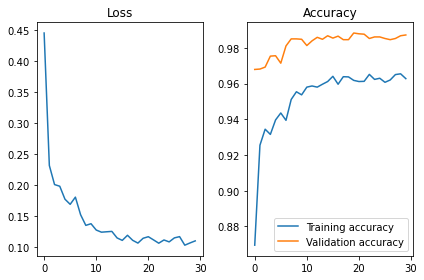

In [13]:
plt.subplot(1,2,1)
plt.plot(loss_vals)
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_acc_vals, label='Training accuracy')
plt.plot(val_acc_vals, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()

On constate que la précision sur l'ensemble d'entraînement reste inférieure à la précision sur l'ensemble de validation. Cela est dû aux transformations aléatoires appliquées sur les exemples d'entraînement.

Le code suivant permet de sauvegarder les coefficients du modèle, pour une utilisation ultérieure.

In [14]:
torch.save(resnext.state_dict(), 'resnext.pt')

Le code suivant permet de charger les coefficients d'un modèle sauvegardé.

In [15]:
resnext.load_state_dict(torch.load('resnext.pt'))
resnext.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## Audio

A chaque scène est associé l'équivalent d'une seconde de données audio, sous forme de coefficients MFCC. Il y a 104 coefficients par scène, qu'on peut diviser en 8 groupes de 13, chaque groupe correspondant à une fenêtre de 0.25 secondes (les fenêtres se chevauchent). On dispose donc d'informations en temps/fréquence.

Visualisons quelques histogrammes des données audio :

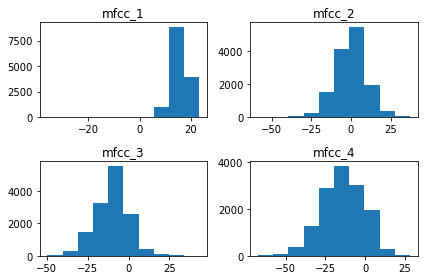

In [16]:
import matplotlib.pyplot as plt

plt.subplot(2,2,1)
plt.hist(audio[::,0])
plt.title('mfcc_1')
plt.subplot(2,2,2)
plt.hist(audio[::,1])
plt.title('mfcc_2')
plt.subplot(2,2,3)
plt.hist(audio[::,2])
plt.title('mfcc_3')
plt.subplot(2,2,4)
plt.hist(audio[::,3])
plt.title('mfcc_4')
plt.tight_layout()

On choisit d'utiliser un réseau de neurones de type MLP, puisque la nature des données s'y prête et que c'est facile à implémenter.

Puisque l'on utilise un réseau de neurone, il est utile de normaliser les donner. Cela permet de faciliter la convergence de l'entraînement.

In [17]:
def normalize(data):
    return (data - np.mean(data, axis=0))/np.std(data, axis=0)
audio_train = normalize(audio_train)
audio_val = normalize(audio_val)

 On utilise un MLP à 3 couches cachées, avec activation Leaky RELU, et régularisation par batch normalization. Notre première approche utilisait seulement une couche cachée, mais après ajout de techniques pour limiter le surapprentissage comme la batch normalization ou les transformations de données aléatoire on a pu rajouter des couches et augmenter les performances.

In [18]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear1 = nn.Linear(104, 156)
        self.bn1 = nn.BatchNorm1d(156)
        
        self.linear2 = nn.Linear(156, 208)
        self.bn2 = nn.BatchNorm1d(208)
        
        self.linear3 = nn.Linear(208, 156)
        self.bn3 = nn.BatchNorm1d(156)
        
        self.linear4 = nn.Linear(156, 104)
        self.bn4 = nn.BatchNorm1d(104)
        
        self.linear5 = nn.Linear(104, 64)
        self.bn5 = nn.BatchNorm1d(64)


        self.final = nn.Linear(64,9)
      
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.linear1(x)))
        x = F.leaky_relu(self.bn2(self.linear2(x)))
        x = F.leaky_relu(self.bn3(self.linear3(x)))
        x = F.leaky_relu(self.bn4(self.linear4(x)))
        x = F.leaky_relu(self.bn5(self.linear5(x)))

        x = self.final(x)
        return x

mlp = MLP().cuda()

Pour limiter le surapprentissage, on peut faire des transformations aléatoires sur les données d'entraînement. Une première idée est d'ajouter un bruit blanc gaussien au données.

In [19]:
class AddGaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Une autre idée, tirant partie de la nature des données, est d'opérer des décalages circulaires aléatoires des fenêtres temporelles.

In [20]:
class RandomCircularShift:      
    def __call__(self, tensor):
        return torch.roll(tensor, 13*np.random.randint(8),dims=0)

Ces transformations seront faites à chaque epoch, si bien que le réseau ne verra jamais deux fois les mêmes données lors de l'entraînement.

Sur Windows, il faut mettre les classes des transformations dans un fichier Python à part.

In [21]:
if os.name == 'nt':
    from transforms import AddGaussianNoise, RandomCircularShift

On crée les datasets et data loaders avec les transformations que l'on a définies.

In [22]:
import torchvision


audio_transform = torchvision.transforms.Compose([
    torch.from_numpy,
    AddGaussianNoise(0.0, 0.1),
    RandomCircularShift(),
])

train_dataset = ImageAudioDataset(root_dir=f'{datadir}/data/data/',
                           files=img_train,
                                 audio=audio_train,
                                 labels=y_train,
                          img_transform=img_train_transform,
                                 audio_transform=audio_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ImageAudioDataset(root_dir=f'{datadir}/data/data/',
                           files=img_val,
                           audio=audio_val,
                           labels=y_val,
                          img_transform=img_val_transform,
                             audio_transform=audio_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

Les mêmes paramètres que pour le classifieur d'image donnent les meilleurs résultats.

In [23]:
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5)

In [24]:
num_epochs = 30
mlp, loss_vals, train_acc_vals, val_acc_vals = train(mlp, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, input_type='audio')

[1,   100] loss: 1.438
[1,   200] loss: 0.996
[1,   300] loss: 0.808
[1,   400] loss: 0.749
[1,   500] loss: 0.643
Learning rate : 0.001
Train accuracy: 0.7175300121307373, validation accuracy : 0.882327139377594
Epoch duration : 27.00717568397522
[2,   100] loss: 0.592
[2,   200] loss: 0.600
[2,   300] loss: 0.551
[2,   400] loss: 0.543
[2,   500] loss: 0.516
Learning rate : 0.001
Train accuracy: 0.8242673277854919, validation accuracy : 0.9099889993667603
Epoch duration : 26.890291213989258
[3,   100] loss: 0.431
[3,   200] loss: 0.464
[3,   300] loss: 0.465
[3,   400] loss: 0.468
[3,   500] loss: 0.450
Learning rate : 0.001
Train accuracy: 0.8516275882720947, validation accuracy : 0.9207464456558228
Epoch duration : 26.927522897720337
[4,   100] loss: 0.408
[4,   200] loss: 0.369
[4,   300] loss: 0.406
[4,   400] loss: 0.400
[4,   500] loss: 0.383
Learning rate : 0.001
Train accuracy: 0.8696874976158142, validation accuracy : 0.9238199591636658
Epoch duration : 27.052207946777344
[5

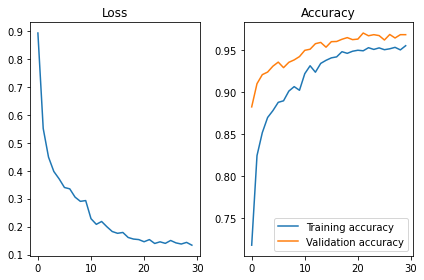

In [25]:
plt.subplot(1,2,1)
plt.plot(loss_vals)
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_acc_vals, label='Training accuracy')
plt.plot(val_acc_vals, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()

On sauvegarde le modèle entrainé.

In [26]:
torch.save(mlp.state_dict(), 'mlp_audio.pt')

In [27]:
mlp.load_state_dict(torch.load('mlp_audio.pt'))
mlp.eval()

MLP(
  (linear1): Linear(in_features=104, out_features=156, bias=True)
  (bn1): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=156, out_features=208, bias=True)
  (bn2): BatchNorm1d(208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=208, out_features=156, bias=True)
  (bn3): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=156, out_features=104, bias=True)
  (bn4): BatchNorm1d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=104, out_features=64, bias=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final): Linear(in_features=64, out_features=9, bias=True)
)

## Classification multimodale

La classification multimodale est faite par un réseau de neurone, composé par les 2 réseaux précédents où l'on concatène les avant dernières couches (late fusion). On entraîne seulement la couche finale. 

In [28]:
class MultimodalClf(nn.Module):
    def __init__(self, img_clf, audio_clf):
        super(MultimodalClf, self).__init__()
        num_ftrs = img_clf.fc.in_features + audio_clf.final.in_features
        self.img_feat = copy.deepcopy(img_clf)
        self.img_feat.fc = nn.Identity()
        self.audio_feat = copy.deepcopy(audio_clf)
        self.audio_feat.final = nn.Identity()
        
        self.bn = nn.BatchNorm1d(num_ftrs)
        self.final = nn.Linear(num_ftrs, 9)
      
    def forward(self, img, audio):
        img_x = self.img_feat(img)
        audio_x = self.audio_feat(audio)
        x = torch.cat((img_x, audio_x), dim=1)
        x = self.bn(x)
        x = self.final(x)
        return x
    
multi_clf = MultimodalClf(resnext, mlp).cuda()
for param in multi_clf.img_feat.parameters():
    param.requires_grad = False
for param in multi_clf.audio_feat.parameters():
    param.requires_grad = False

On constate que l'ajout de batch normalization avant la dernière couche donne de meilleures performances. Elle permet ici de mettre à la même echelle les features extraites par le réseau pour les images et celui pour l'audio.

On construit les data loaders avec les transformations sur les images et sur l'audio.

In [29]:
img_train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img_val_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
audio_transform = torchvision.transforms.Compose([
    torch.from_numpy,
    AddGaussianNoise(0.0, 0.1),
    RandomCircularShift(),
])
train_dataset = ImageAudioDataset(root_dir=f'{datadir}/data/data/',
                           files=img_train,
                                 audio=audio_train,
                                 labels=y_train,
                          img_transform=img_train_transform,
                                 audio_transform=audio_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ImageAudioDataset(root_dir=f'{datadir}/data/data/',
                           files=img_val,
                           audio=audio_val,
                           labels=y_val,
                          img_transform=img_val_transform,
                             audio_transform=None)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [30]:
optimizer = optim.Adam(multi_clf.final.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5)

In [31]:
num_epochs = 30
multi_clf, loss_vals, train_acc_vals, val_acc_vals = train(multi_clf, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, input_type='multimodal')

[1,   100] loss: 0.411
[1,   200] loss: 0.139
[1,   300] loss: 0.094
[1,   400] loss: 0.067
[1,   500] loss: 0.078
Learning rate : 0.001
Train accuracy: 0.9565264582633972, validation accuracy : 0.994731068611145
Epoch duration : 37.205570936203
[2,   100] loss: 0.059
[2,   200] loss: 0.057
[2,   300] loss: 0.045
[2,   400] loss: 0.044
[2,   500] loss: 0.051
Learning rate : 0.001
Train accuracy: 0.9845355153083801, validation accuracy : 0.9949505925178528
Epoch duration : 37.34316349029541
[3,   100] loss: 0.032
[3,   200] loss: 0.040
[3,   300] loss: 0.073
[3,   400] loss: 0.049
[3,   500] loss: 0.060
Learning rate : 0.0005
Train accuracy: 0.9841029644012451, validation accuracy : 0.9927552342414856
Epoch duration : 37.292946577072144
[4,   100] loss: 0.058
[4,   200] loss: 0.030
[4,   300] loss: 0.022
[4,   400] loss: 0.034
[4,   500] loss: 0.017
Learning rate : 0.0005
Train accuracy: 0.9902671575546265, validation accuracy : 0.9964873790740967
Epoch duration : 37.23304057121277
[5, 

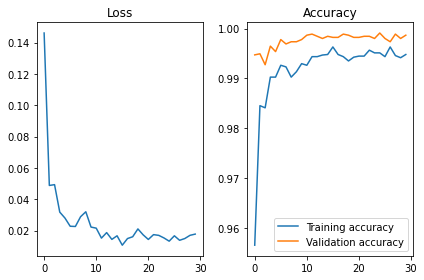

In [32]:
plt.subplot(1,2,1)
plt.plot(loss_vals)
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_acc_vals, label='Training accuracy')
plt.plot(val_acc_vals, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()

Visualisation d'exemples de données de validation mal classées :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7) tensor(6, device='cuda:0')
True label : GROCERY-STORE, predicted : RESTAURANT
tensor(8) tensor(6, device='cuda:0')
True label : FOOTBALL-MATCH, predicted : RESTAURANT
tensor(8) tensor(7, device='cuda:0')
True label : FOOTBALL-MATCH, predicted : GROCERY-STORE
tensor(6) tensor(4, device='cuda:0')
True label : RESTAURANT, predicted : RIVER


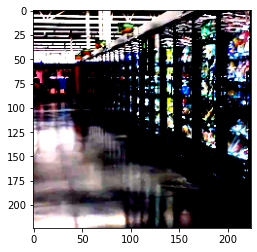

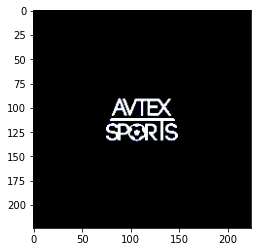

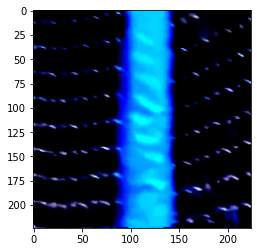

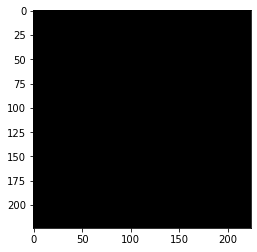

In [33]:
_,incorrect_pred = predict(multi_clf, val_loader,has_labels=True,input_type='multimodal')
for img, mfcc, true_label, pred_label in incorrect_pred:
    print(true_label, pred_label)
    print(f'True label : {class_list[true_label]}, predicted : {class_list[pred_label]}')
    #print(f'Audio MFCC (normalized) : {mfcc}')
    plt.figure()
    plt.imshow(img.cpu().permute(1, 2, 0) )

Parmi les scènes que le modèle n'arrive pas à classer, on retrouve des écrans noirs, qui correspondent à des génériques ou des écrans titre (le dataset a été généré à partir de vidéos). Il est difficile de dire si les données audio peuvent aider à classer ces scènes, car on ne connaît pas le son original (la transformée en MFCC n'est pas inversible).

Ce n'est pas visible ici, mais avec des hyperparamètres ou des graines différentes on peut voir que quelques fois le modèle classifie certaines scènes de forêt comme rivière ou vice-versa. Cela n'est pas anormal car ces classes ne sont pas vraiment mutuellement exclusives.

JUNGLE


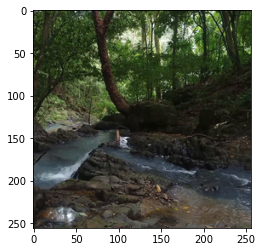

In [61]:
# visu image
idx = 5084
class_list = ['FOREST', 'CITY', 'BEACH', 'CLASSROOM', 'RIVER', 'JUNGLE', 'RESTAURANT', 'GROCERY-STORE', 'FOOTBALL-MATCH']
img = Image.open(f'{datadir}/data/data/{img_list[idx]}')
plt.imshow(np.asarray(img))
print(class_list[labels[idx]])

In [34]:
torch.save(multi_clf.state_dict(), 'multi_clf.pt')

In [35]:
multi_clf.load_state_dict(torch.load('multi_clf.pt'))
multi_clf.eval()

MultimodalClf(
  (img_feat): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample)

## Soumission résultats test

Chargement données de test.

In [36]:
testdata = pd.read_csv(os.path.join(datadir,'data_test_novt.csv'), delimiter=',', nrows = None)
data = np.array(testdata)

audio_test = np.array(data[:, 1:], dtype='float32')

testimg_list = testdata['IMAGE']

audio_test = normalize(audio_test)

Création du data loader pour les données de test 

In [37]:
test_dataset = ImageAudioDataset(root_dir=f'{datadir}/data/data/',
                           files=testimg_list,
                                 audio=audio_test,
                                 labels=None,
                          img_transform=img_val_transform,
                                 audio_transform=None)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

On peut faire les prédictions sur les données de test avec le modèle entraîné sur les données d'entraînement privé de l'ensemble de validation, ou bien réentrainer le modèle sur l'ensemble d'entraînement complet.
L'avantage d'utiliser l'ensemble d'entraînement complet et que l'on utilise plus de données, mais on a moins de contrôle sur un éventuel surapprentissage.

#### Prédictions en utilisant l'ensemble d'entraînement partiel

In [38]:
#====================================================================
# Création du ficher de soumission
y_pred = predict(multi_clf, test_loader, input_type='multimodal')
submission = pd.DataFrame({'CLASS':y_pred})
submission=submission.reset_index()
submission = submission.rename(columns={'index': 'Id'})

#======================================================================
# Sauvegarde du fichier
submission.to_csv('submission_part.csv', index=False)

#### Prédictions en utilisant l'ensemble d'entraînement complet

Création du data loader pour les données d'entrainement complètes

In [39]:
train_dataset = ImageAudioDataset(root_dir=f'{datadir}/data/data/',
                           files=img_list,
                                 audio=normalize(audio),
                                 labels=labels,
                          img_transform=img_train_transform,
                                 audio_transform=audio_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

Entraînement du MLP classifieur sur les données audio complètes

In [40]:
mlp = MLP().cuda()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5)
mlp, loss_vals, train_acc_vals = train(mlp, train_loader, None, criterion, optimizer, scheduler, num_epochs=30, input_type='audio')

[1,   100] loss: 1.524
[1,   200] loss: 0.996
[1,   300] loss: 0.807
[1,   400] loss: 0.728
[1,   500] loss: 0.701
[1,   600] loss: 0.648
[1,   700] loss: 0.677
[1,   800] loss: 0.603
Learning rate : 0.001
Train accuracy: 0.7442399263381958
Epoch duration : 23.307010889053345
[2,   100] loss: 0.562
[2,   200] loss: 0.548
[2,   300] loss: 0.503
[2,   400] loss: 0.486
[2,   500] loss: 0.475
[2,   600] loss: 0.431
[2,   700] loss: 0.480
[2,   800] loss: 0.400
Learning rate : 0.001
Train accuracy: 0.8456745147705078
Epoch duration : 23.34277629852295
[3,   100] loss: 0.451
[3,   200] loss: 0.422
[3,   300] loss: 0.442
[3,   400] loss: 0.434
[3,   500] loss: 0.408
[3,   600] loss: 0.414
[3,   700] loss: 0.416
[3,   800] loss: 0.415
Learning rate : 0.001
Train accuracy: 0.8623387813568115
Epoch duration : 23.240138292312622
[4,   100] loss: 0.346
[4,   200] loss: 0.391
[4,   300] loss: 0.373
[4,   400] loss: 0.367
[4,   500] loss: 0.322
[4,   600] loss: 0.365
[4,   700] loss: 0.399
[4,   800

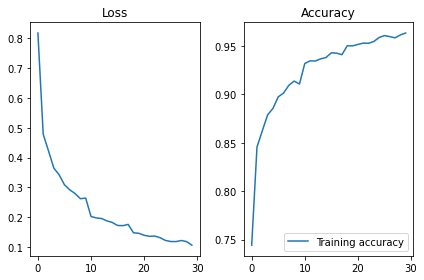

In [41]:
plt.subplot(1,2,1)
plt.plot(loss_vals)
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_acc_vals, label='Training accuracy')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()

Entraînement du classifieur multimodal sur les données complètes

In [42]:
multi_clf = MultimodalClf(resnext, mlp).cuda()
for param in multi_clf.img_feat.parameters():
    param.requires_grad = False
for param in multi_clf.audio_feat.parameters():
    param.requires_grad = False

In [43]:
optimizer = optim.Adam(multi_clf.final.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=0,factor=0.5)
multi_clf, loss_vals, train_acc_vals = train(multi_clf, train_loader, None, criterion, optimizer, scheduler, num_epochs=30, input_type='multimodal')

[1,   100] loss: 0.400
[1,   200] loss: 0.120
[1,   300] loss: 0.104
[1,   400] loss: 0.071
[1,   500] loss: 0.086
[1,   600] loss: 0.061
[1,   700] loss: 0.052
[1,   800] loss: 0.040
Learning rate : 0.001
Train accuracy: 0.9669612646102905
Epoch duration : 34.288822650909424
[2,   100] loss: 0.040
[2,   200] loss: 0.056
[2,   300] loss: 0.036
[2,   400] loss: 0.043
[2,   500] loss: 0.035
[2,   600] loss: 0.036
[2,   700] loss: 0.043
[2,   800] loss: 0.040
Learning rate : 0.001
Train accuracy: 0.9860165119171143
Epoch duration : 34.43674039840698
[3,   100] loss: 0.033
[3,   200] loss: 0.035
[3,   300] loss: 0.022
[3,   400] loss: 0.027
[3,   500] loss: 0.045
[3,   600] loss: 0.036
[3,   700] loss: 0.041
[3,   800] loss: 0.025
Learning rate : 0.001
Train accuracy: 0.9884074330329895
Epoch duration : 33.94582176208496
[4,   100] loss: 0.040
[4,   200] loss: 0.027
[4,   300] loss: 0.035
[4,   400] loss: 0.031
[4,   500] loss: 0.025
[4,   600] loss: 0.023
[4,   700] loss: 0.036
[4,   800]

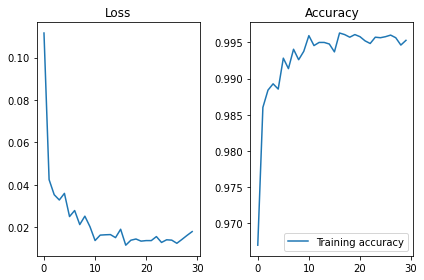

In [44]:
plt.subplot(1,2,1)
plt.plot(loss_vals)
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_acc_vals, label='Training accuracy')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()

Sauvegarde du modèle entraîné sur les données complètes.

In [45]:
torch.save(multi_clf.state_dict(), 'multi_clf_cplt.pt')

In [46]:
multi_clf.load_state_dict(torch.load('multi_clf_cplt.pt'))
multi_clf.eval()

MultimodalClf(
  (img_feat): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample)

Prédictions sur les données de test

In [47]:
#====================================================================
# Création du ficher de soumission
y_pred = predict(multi_clf, test_loader, input_type='multimodal')
submission = pd.DataFrame({'CLASS':y_pred})
submission=submission.reset_index()
submission = submission.rename(columns={'index': 'Id'})

#======================================================================
# Sauvegarde du fichier
submission.to_csv('submission.csv', index=False)

## Performances et perspectives d'amélioration

On obtient environ 99.9% de précision que cela soit sur l'ensemble de validation ou l'ensemble de test. Si les performances sont aussi élevées, c'est probablement car l'ensemble de test contient des exemples trop proches de l'ensemble d'entraînement.

Il serait intéressant de pouvoir mesurer les performances du modèles sur des données totalement différentes de celles de l'ensemble d'entraînement.

Pour la classification à partir des données audio, on pourrait peut être bénéficier à apprendre les features à partir du signal audio plutôt qu'utiliser des coefficients MFCC (qui ne permettent pas de retrouver le signal original). Cela permettrait d'essayer une plus grande variété d'approches, comme des réseaux convolutionnels 1d, ou des CNN classiques appliqués aux spectrogrammes, des RNN, etc.